# EDA of Datasets

**Purpose:** Understand the dataset and define research questions.

**Research Questions:**

- *RQ1:* Can a fine-tuned open-weight language model reliably identify the eight review aspects (Summary, Motivation, …, Clarity) and their polarity in peer reviews?
- *RQ2:* Does augmenting a fine-tuned transformer with detected aspect–polarity spans plus year & submission-volume features improve its ability to predict each review’s numerical rating and confidence score?



## ICLR

### Investigation of Review Aspects

In [1]:
import pandas as pd
ASPECT_PTH = "dataset/aspect_data/review_with_aspect.jsonl"
aspects_df = pd.read_json(ASPECT_PTH, lines=True)

In [2]:
aspects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25986 entries, 0 to 25985
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25986 non-null  object
 1   text    25986 non-null  object
 2   labels  25986 non-null  object
dtypes: object(3)
memory usage: 609.2+ KB


8792 reviews has been assigned an aspect. 5154 of them from ICLR while 3588 from NIPS.

In [3]:
aspects_df["id"].nunique()

8742

In [4]:
aspects_df[aspects_df["id"].str.startswith("ICLR")]["id"].nunique()

5154

In [5]:
aspects_df[aspects_df["id"].str.startswith("NIPS")]["id"].nunique()

3588

In [6]:
aspects_df.head()

,id,text,labels
0,ICLR_2020_1123,This work studies the predictive uncertainty i...,"[[0, 1029, summary], [1030, 1201, motivation_p..."
1,ICLR_2018_813,Summary : This paper proposes a new approach t...,"[[10, 1038, summary], [1054, 1082, motivation_..."
2,NIPS_2019_796,The paper proposes a graph neural network base...,"[[0, 469, summary], [470, 532, clarity_positiv..."
3,ICLR_2018_726,Summary : This paper proposes an encoder-decod...,"[[10, 599, summary], [870, 1076, substance_neg..."
4,NIPS_2016_477,The authors present sharp criteria for l_1-spa...,"[[0, 1223, summary], [1314, 1354, soundness_po..."


In [7]:
aspects_df["labels"][0]

[[0, 1029, 'summary'],
 [1030, 1201, 'motivation_positive'],
 [1204, 1292, 'clarity_positive'],
 [1293, 1409, 'soundness_negative'],
 [1555, 1656, 'substance_negative'],
 [1973, 1998, 'meaningful_comparison_negative'],
 [3389, 3508, 'soundness_negative']]

---

We can see that most frequent aspect assigned is `summary`. It can be explained as the most of the reviewers begin by writing a summary about paper before writing their thoughts.

We can see that aspects also has their polarity as `negative` or `positive`. Non occurence of an aspect may be thought as neutrality.



In [ ]:
labels = [i[2] for d in aspects_df["labels"] for i in d]

from collections import Counter
label_counts = Counter(labels)
label_counts

Counter({'summary': 23946,
         'clarity_negative': 15697,
         'soundness_negative': 15662,
         'clarity_positive': 13095,
         'soundness_positive': 12780,
         'substance_negative': 11717,
         'originality_positive': 11606,
         'motivation_positive': 11121,
         'meaningful_comparison_negative': 9242,
         'originality_negative': 8745,
         'substance_positive': 4669,
         'replicability_negative': 4548,
         'motivation_negative': 3499,
         'meaningful_comparison_positive': 1488,
         'replicability_positive': 271})

---

The chart below shows the distribution of aspect labels, which have been sorted alphabetically to make polarity comparisons easier.

We observe several issues:

- **Meaningful comparison** appears almost exclusively with negative polarity. As a result, identifying positive instances of this label will be challenging due to class imbalance.

- **Motivation** is used predominantly in a positive sense and also suffers from imbalance.

- **Replicability** has very few total samples—and virtually no positive examples—creating another significant skew.

To address these problems, we might consider:

1. Dropping the label entirely

2. Treating the label by ignoring its polarity.  

3. Augmenting the dataset to increase the sample count for underrepresented label-polarity combinations.


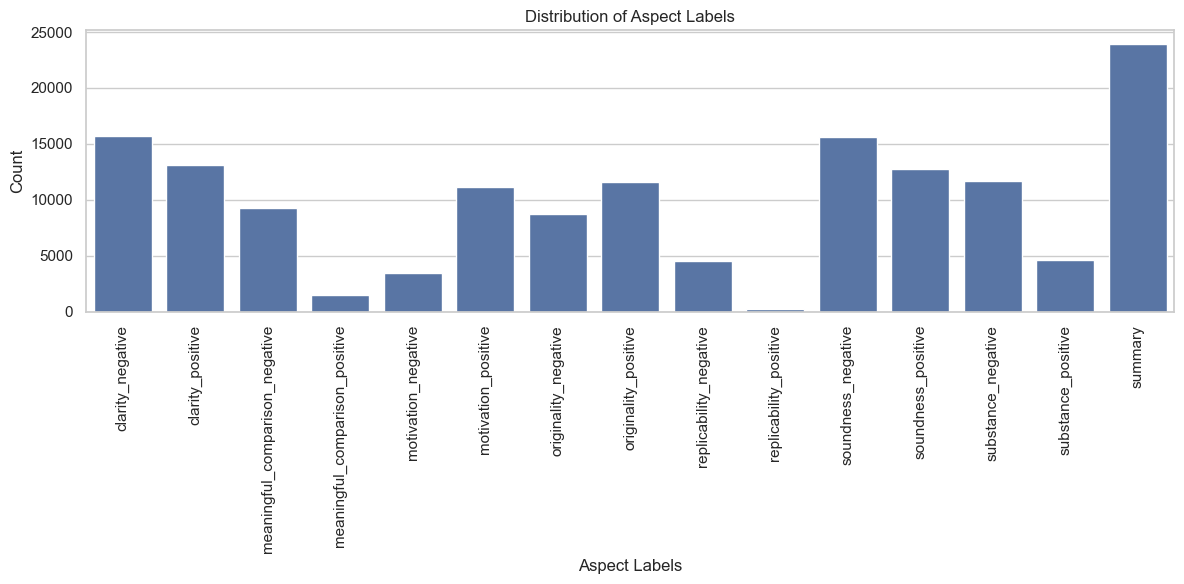

In [114]:

label_counts = dict(sorted(label_counts.items()))
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.xticks(rotation=90)
plt.xlabel("Aspect Labels")
plt.ylabel("Count")
plt.title("Distribution of Aspect Labels")
plt.tight_layout()
plt.show()


---

### Investigation of Papers and Reviews

---

Two datasets were gathered from ICLR (2017–2020) and NIPS (2016–2019). However, the data collector points out that the NIPS set lacks any records of rejected submissions.

In [20]:
!printf "ICLR Papers:\n" && ls dataset/ |grep "ICLR*" && printf "\nNIPS Papers:\n" && ls dataset/ |grep "NIPS*"

ICLR Papers:
ICLR_2017
ICLR_2018
ICLR_2019
ICLR_2020

NIPS Papers:
NIPS_2016
NIPS_2017
NIPS_2018
NIPS_2019


---

As illustrated below, both conferences show increasing sample counts in more recent years. Moreover, ICLR’s annual totals closely track those of NIPS. This can cause overfitting when training a model to predict paper rejections.

In [23]:
!for year in 2017 2018 2019 2020; do printf "ICLR $year Paper Count:" && ls -altr dataset/ICLR_${year}/ICLR_${year}_paper/ | wc -l; done

ICLR 2017 Paper Count:     492
ICLR 2018 Paper Count:     914
ICLR 2019 Paper Count:    1582
ICLR 2020 Paper Count:    2216


In [ ]:
!for year in 2016 2017 2018 2019; do printf "NIPS $year Paper Count:" && ls -altr dataset/NIPS_${year}/NIPS_${year}_paper/ | wc -l; done

NIPS 2016 Paper Count:     572
NIPS 2017 Paper Count:     682
NIPS 2018 Paper Count:    1012
NIPS 2019 Paper Count:    1431


---

The figure below reveals a slight discrepancy between the total papers and the total reviews: some papers have no associated review information. These entries should be identified and, if necessary for our research objectives, removed from the dataset.

In [25]:
!for year in 2017 2018 2019 2020; do printf "ICLR $year Review Count:" && ls -altr dataset/ICLR_${year}/ICLR_${year}_review/ | wc -l; done

ICLR 2017 Review Count:     493
ICLR 2018 Review Count:     913
ICLR 2019 Review Count:    1568
ICLR 2020 Review Count:    2216


In [26]:
!for year in 2016 2017 2018 2019; do printf "NIPS $year Review Count:" && ls -altr dataset/NIPS_${year}/NIPS_${year}_review/ | wc -l; done

NIPS 2016 Review Count:     561
NIPS 2017 Review Count:     670
NIPS 2018 Review Count:     991
NIPS 2019 Review Count:    1392


---

In [116]:
"""
This script processes ICLR conference papers and reviews from 2017 to 2020.
It extracts relevant information from JSON files and stores it in pandas DataFrames.
The script assumes the following directory structure:
dataset/
    ├── ICLR_2017
    │   ├── ICLR_2017_paper/
    │   └── ICLR_2017_review/
    ├── ICLR_2018
    │   ├── ICLR_2018_paper/
    │   └── ICLR_2018_review/
    ├── ICLR_2019
    │   ├── ICLR_2019_paper/
    │   └── ICLR_2019_review/
    └── ICLR_2020
        ├── ICLR_2020_paper/
        └── ICLR_2020_review/

The script reads JSON files from the specified directories, extracts paper IDs, decisions, reviews, and ratings, and stores them in pandas DataFrames.
"""
base_folder = "dataset"

iclr_paper_rows = []
iclr_review_rows = []
years = range(2017, 2021)  # 2017 to 2020 inclusive

for year in years:
    iclr_paper_folder = os.path.join(base_folder, f"ICLR_{year}", f"ICLR_{year}_paper")
    if not os.path.exists(iclr_paper_folder):
        print(f"Warning: {iclr_paper_folder} not found, skipping.")
        continue

    for filename in os.listdir(iclr_paper_folder):
        if filename.endswith('.json'):
            file_path = os.path.join(iclr_paper_folder, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                paper_id = data.get('id')
                decision = data.get('decision')
                hasReview = data.get('hasReview')
                iclr_paper_rows.append({
                    'paper_id': paper_id,
                    'decision': decision,
                    'hasReview': hasReview,
                    'year': year
                })
iclr_paper_df = pd.DataFrame(iclr_paper_rows)


for year in years:
    iclr_review_path = os.path.join(base_folder, f"ICLR_{year}", f"ICLR_{year}_review")
    
    if not os.path.exists(iclr_review_path):
        print(f"Warning: {iclr_review_path} not found, skipping.")
        continue

    for filename in os.listdir(iclr_review_path):
        if filename.endswith('.json'):
            file_path = os.path.join(iclr_review_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                paper_id = data.get('id')
                review_counter = 1  # Reset review counter for each paper
                for review_entry in data.get('reviews', []):
                    review_text = review_entry.get('review', '')
                    rating_text = review_entry.get('rating', '')
                    # Extract the integer part of the rating
                    rating_int = int(rating_text.split(':')[0].strip()) if rating_text else None

                    iclr_review_rows.append({
                        'review_id': f'{paper_id}_{review_counter}',
                        'paper_id': paper_id,
                        'review': review_text,
                        'rating': rating_int
                    })
                    review_counter += 1

iclr_reviews_df = pd.DataFrame(iclr_review_rows)


---
Information about the contents of `paper_df` and `reviews_df`. It shows that there are approxiamitly 5 reviews per paper.

In [ ]:
iclr_paper_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5192 entries, 0 to 5191
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   5192 non-null   object
 1   decision   5192 non-null   object
 2   hasReview  5192 non-null   object
 3   year       5192 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 162.4+ KB


In [ ]:
iclr_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31462 entries, 0 to 31461
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  31462 non-null  object
 1   paper_id   31462 non-null  object
 2   review     31462 non-null  object
 3   rating     31462 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 983.3+ KB


---

As can be seen below, all informations are filled on both of the dataframes.

In [ ]:
iclr_paper_df.isnull().sum()

paper_id     0
decision     0
hasReview    0
year         0
dtype: int64

In [ ]:
iclr_reviews_df.isnull().sum()

review_id    0
paper_id     0
review       0
rating       0
dtype: int64

---

The dataset includes multiple acceptance categories but only a single rejection label. Since our objective isn’t to decide whether or where a paper should be accepted, the distinctions among accept categories possibly not meaningful.

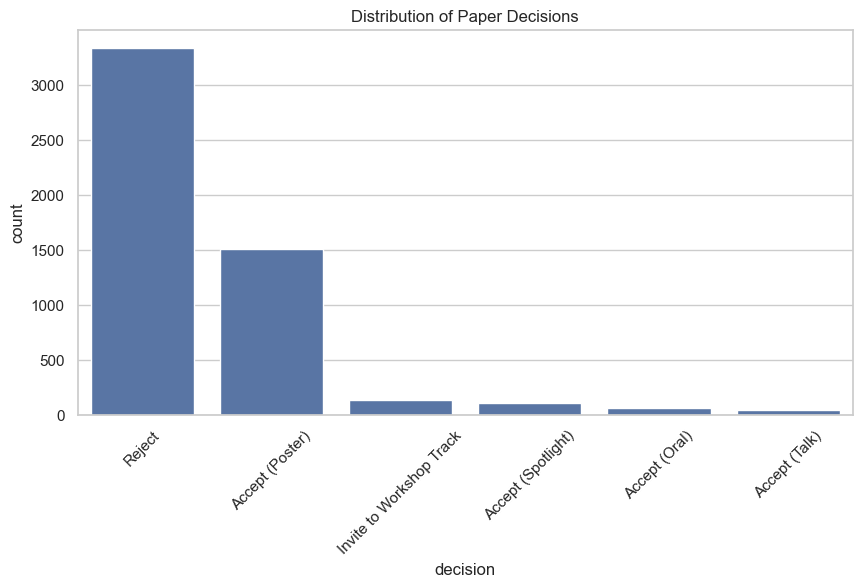

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(data=iclr_paper_df, x='decision', order=iclr_paper_df['decision'].value_counts().index)
plt.title('Distribution of Paper Decisions')
plt.xticks(rotation=45)
plt.show()


---

The ICLR dataset contains nearly twice as many rejected samples as accepted ones. This imbalance must be carefully handled to prevent the model from constantly rejecting every paper simply to inflate accuracy.

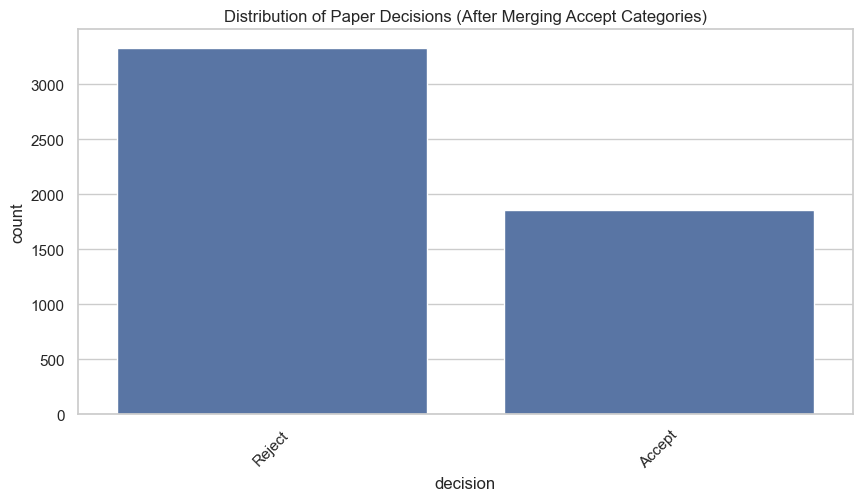

decision
Reject    3333
Accept    1859
Name: count, dtype: int64


In [126]:

# collect all decisions that are not "Reject" to one category, which is "Accept"
iclr_paper_df['decision'] = iclr_paper_df['decision'].replace(['Accept', 'Accept (Oral)', 'Accept (Spotlight)', 'Accept (Poster)', 'Accept (Talk)', 'Invite to Workshop Track'], 'Accept')
plt.figure(figsize=(10,5))
sns.countplot(data=iclr_paper_df, x='decision', order=iclr_paper_df['decision'].value_counts().index)
plt.title('Distribution of Paper Decisions (After Merging Accept Categories)')
plt.xticks(rotation=45)
plt.show()

print(iclr_paper_df['decision'].value_counts())

---

The chart below illustrates yearly acceptance versus rejection rates.

In 2017 and 2018, approximately half of all submissions were accepted. In later years, likely driven by higher submission volumes, the number of rejections rose sharply.

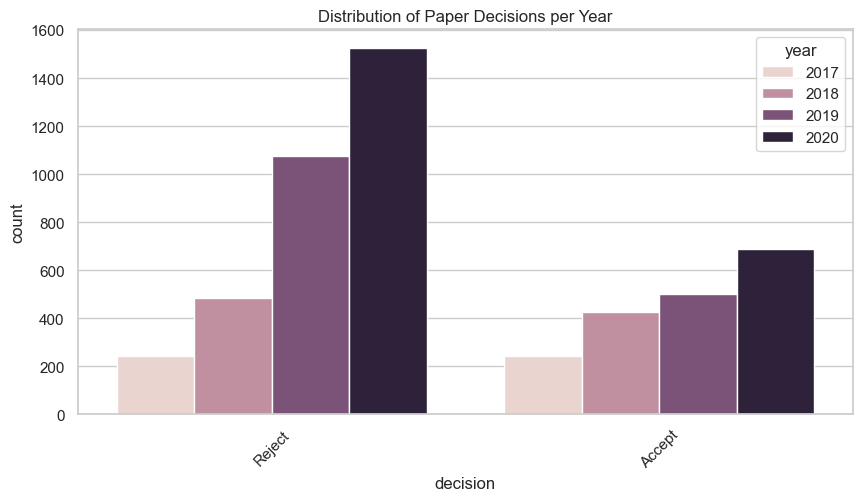

In [121]:
# show the distribution of paper decisions per year
plt.figure(figsize=(10,5))
sns.countplot(data=iclr_paper_df, x='decision', hue='year', order=iclr_paper_df['decision'].value_counts().index)
plt.title('Distribution of Paper Decisions per Year')
plt.xticks(rotation=45)
plt.show()

---

The graph below shows:

- How many tokens in each review (x axis)?

- How many reviews has that much of tokens (y axis)?

We can see that most of the reviews contains tokens less than 1000 with average of 389. This is a good score considering importance of lengths in transformer models. The result shows that we would not need massive truncation to fit most of the reviews into common transformer models such as BERT and RoBERTa.

We should note that the token count does not shows the word count. Since the text data has not been preprocessed yet, the resulting length probably higher than what we will use in training part.


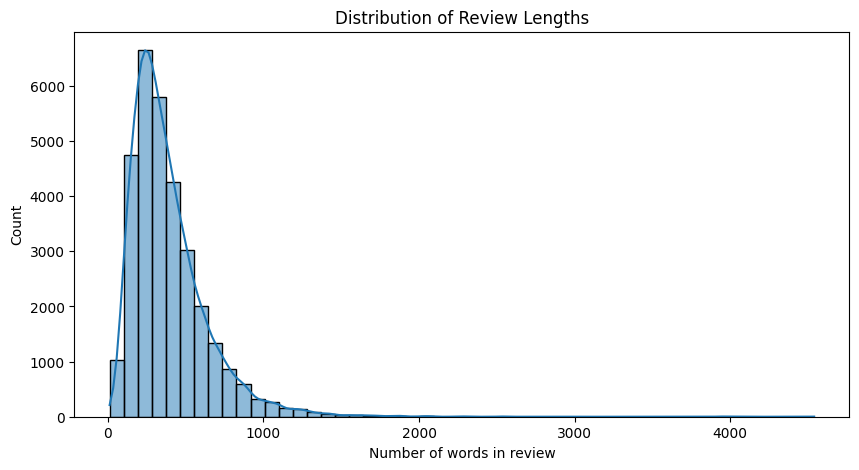

count    31462.000000
mean       389.990274
std        250.830021
min         11.000000
25%        222.000000
50%        332.000000
75%        493.000000
max       4540.000000
Name: review_length, dtype: float64


In [ ]:

iclr_reviews_df['review_length'] = iclr_reviews_df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(iclr_reviews_df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of words in review')
plt.show()

print(iclr_reviews_df['review_length'].describe())


---

The below graph shows distribution of ratings of reviews. The graph shows that there is a cumulation of samples between 3 and 6.

Ratings may be grouped as following:

| Rate  | Group     |
|-------|------
| 1 - 4 | Strong Rejection  |
|   5   | Borderline Rejection |
|   6   | Borderline Acceptance |
| 7 - 10| Stong Acceptance |

Scores of 5 and 6 likely reflect reviewer uncertainty between acceptance and rejection, and thus may contain mixed signals. Excluding these ambiguous “borderline” reviews could improve classifier performance. We will decide later whether to remove them from the dataset.

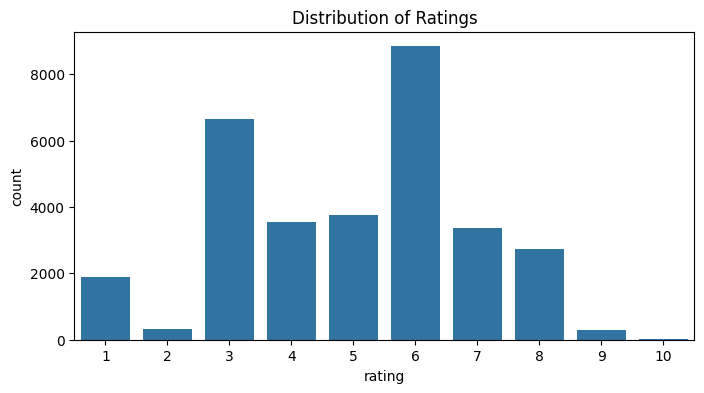

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=iclr_reviews_df, x='rating', order=sorted(iclr_reviews_df['rating'].dropna().unique())) 
plt.title('Distribution of Ratings')
plt.show()


---

Most rejection decisions appear to have been made with high confidence, while acceptance ratings show comparatively lower reviewer certainty. Training a model exclusively on the ICLR dataset—where strong negative ratings dominate—could bias it toward generating scores that are more negative. 

In [ ]:
iclr_reviews_df["ratingGroups"] = iclr_reviews_df["rating"].apply(
    lambda x:   'Strong Rejection' if 1 <= x <= 4 else
                'Borderline Rejection' if 5 == x else
                'Borderline Acceptance' if 6 == x else
                'Strong Acceptance' if 7 <= x <= 10 else
                'Unk'
)



In [ ]:
iclr_reviews_df['ratingGroups'].value_counts()

ratingGroups
Strong Rejection         12418
Borderline Acceptance     8838
Strong Acceptance         6444
Borderline Rejection      3762
Name: count, dtype: int64

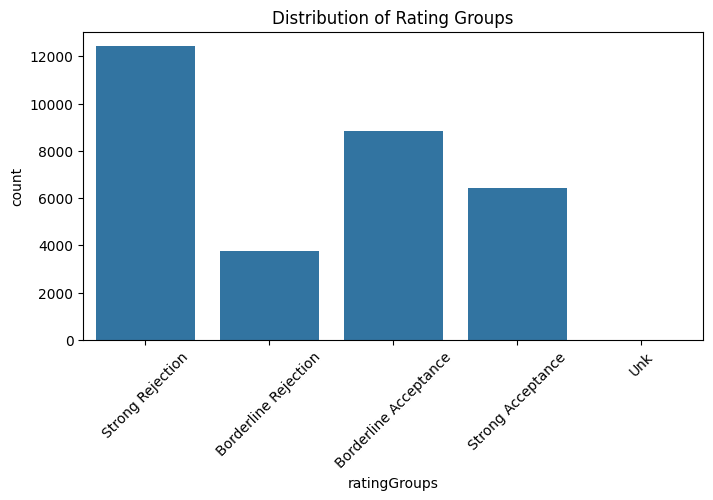

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=iclr_reviews_df, x='ratingGroups', order=["Strong Rejection", "Borderline Rejection", "Borderline Acceptance", "Strong Acceptance", "Unk"]) 
plt.title('Distribution of Rating Groups')
plt.xticks(rotation=45)
plt.show()


---

As shown in the graphs below, acceptance rates have declined significantly over the years. One key reason for this trend is the growing number of paper submissions to the conferences.

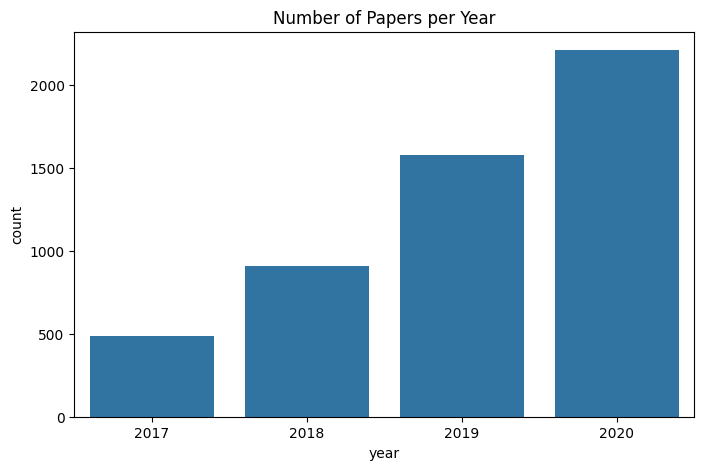

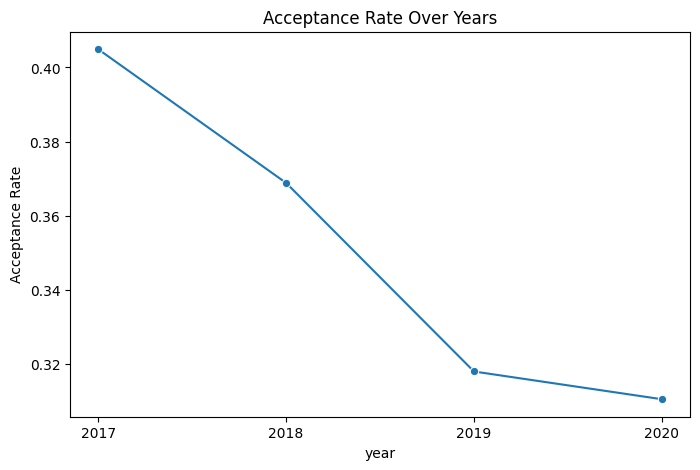

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=iclr_paper_df, x='year')
plt.title('Number of Papers per Year')
plt.show()

ac = iclr_paper_df.copy()
ac_rate['year'] = ac_rate['year'].astype(int)
ac['is_accepted'] = ac['decision'].apply(lambda x: 1 if 'Accept' in x else 0)
ac_rate = ac.groupby('year')['is_accepted'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.lineplot(data=ac_rate, x='year', y='is_accepted', marker='o')
plt.xticks(ac_rate["year"].tolist()) 
plt.title('Acceptance Rate Over Years')
plt.ylabel('Acceptance Rate')
plt.show()



---

The graph below shows the yearly changes in both the number of submitted and accepted papers. We observe a simultaneous increase in both metrics—meaning the conference has been accepting more papers each year. However, because the number of submissions has grown at a much faster rate, the overall acceptance rate appears to have declined.

This trend suggests that review scores might not purely reflect a paper's absolute quality, but rather its quality relative to an increasingly competitive applicant pool. A strong score might indicate a standout paper in a particularly crowded year, while a borderline score could simply reflect strong competition rather than lower quality.

Paper quality, reviewer biases, and external factors like increased submissions all influence review scores. As a result:

- A paper in a later year might receive a higher score for comparable quality, as reviewers become more selective due to the volume of submissions.  
- It may be necessary to include features related to submission year and submission volume in the model.  
- A time-series approach could help capture shifts in scoring behavior over the years.


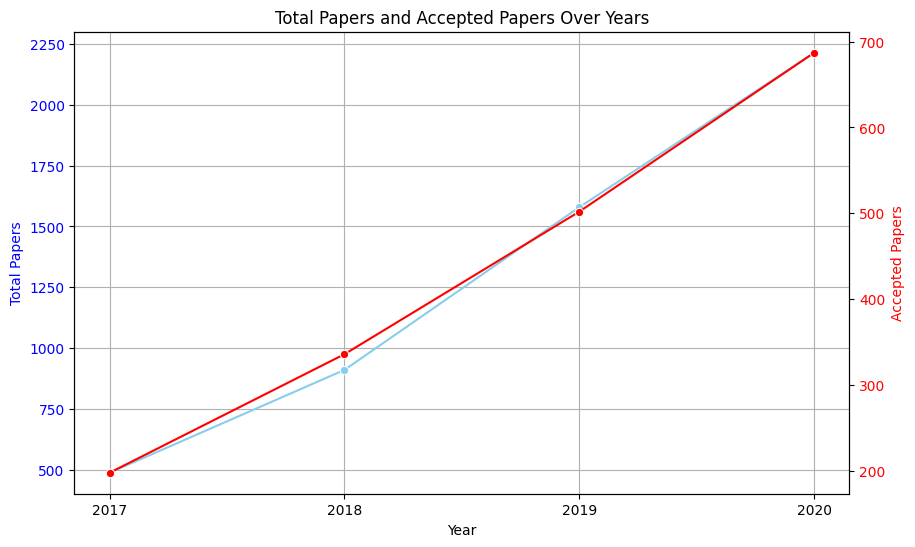

In [ ]:

accept_sum = ac.groupby('year').agg(
    total_papers=('paper_id', 'count'),
    accepted_papers=('is_accepted', 'sum')
).reset_index()

fig, ax1 = plt.subplots(figsize=(10,6))

sns.lineplot(x=accept_sum['year'], y=accept_sum['total_papers'], marker='o', color='skyblue', ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Papers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
sns.lineplot(x=accept_sum['year'], y=accept_sum['accepted_papers'], marker='o', color='red', ax=ax2)
ax2.set_ylabel('Accepted Papers', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.xticks(ac_rate["year"].tolist()) 

plt.title('Total Papers and Accepted Papers Over Years')
ax1.grid(True)

plt.show()


---

## NIPS

---



In [95]:

nips_paper_rows = []
nips_review_rows = []
years = range(2016, 2020)  # 201 to 2019 inclusive

for year in years:
    nips_paper_folder = os.path.join(base_folder, f"nips_{year}", f"nips_{year}_paper")
    if not os.path.exists(nips_paper_folder):
        print(f"Warning: {nips_paper_folder} not found, skipping.")
        continue

    for filename in os.listdir(nips_paper_folder):
        if filename.endswith('.json'):
            file_path = os.path.join(nips_paper_folder, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                paper_id = data.get('id')
                decision = data.get('decision')
                hasReview = data.get('hasReview')
                nips_paper_rows.append({
                    'paper_id': paper_id,
                    'decision': decision,
                    'hasReview': hasReview,
                    'year': year
                })
nips_paper_df = pd.DataFrame(nips_paper_rows)


for year in years:
    nips_review_path = os.path.join(base_folder, f"nips_{year}", f"nips_{year}_review")
    
    if not os.path.exists(nips_review_path):
        print(f"Warning: {nips_review_path} not found, skipping.")
        continue

    for filename in os.listdir(nips_review_path):
        if filename.endswith('.json'):
            file_path = os.path.join(nips_review_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                paper_id = data.get('id')
                review_counter = 1  # Reset review counter for each paper
                for review_entry in data.get('reviews', []):
                    review_text = review_entry.get('review', '')
                    rating_text = review_entry.get('rating', '')
                    # Extract the integer part of the rating
                    rating_int = int(rating_text.split(':')[0].strip()) if rating_text else None

                    nips_review_rows.append({
                        'review_id': f'{paper_id}_{review_counter}',
                        'paper_id': paper_id,
                        'review': review_text,
                        'rating': rating_int
                    })
                    review_counter += 1

nips_reviews_df = pd.DataFrame(nips_review_rows)


---

There is an inconsistency between the NIPS and ICLR datasets: NIPS reviews do not include rating scores.

This poses a challenge for the Review Score Prediction (RSP) task, as it means the NIPS dataset cannot be directly used to train an RSP model. 
There may be need to a separate dataset to properly train an RSP model.

In [96]:
nips_paper_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3685 entries, 0 to 3684
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   3685 non-null   object
 1   decision   3685 non-null   object
 2   hasReview  3685 non-null   object
 3   year       3685 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 115.3+ KB


In [97]:
nips_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12391 entries, 0 to 12390
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  12391 non-null  object
 1   paper_id   12391 non-null  object
 2   review     12391 non-null  object
 3   rating     0 non-null      object
dtypes: object(4)
memory usage: 387.3+ KB


---


In [98]:
nips_paper_df.isnull().sum()

paper_id     0
decision     0
hasReview    0
year         0
dtype: int64

In [99]:
nips_reviews_df.isnull().sum()

review_id        0
paper_id         0
review           0
rating       12391
dtype: int64

---

We already know that all NIPS papers in the dataset are accepted. However, we also observe that there are no "Accept" rating groups recorded for them, unlike what we see in the ICLR dataset.


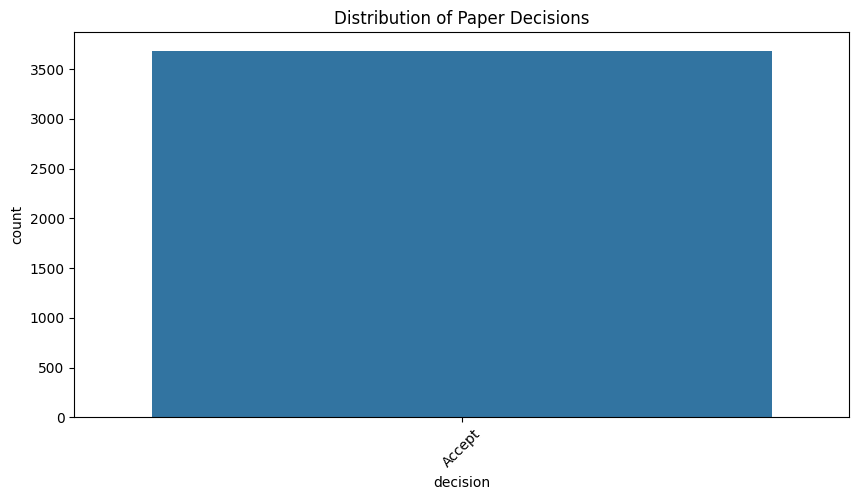

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(data=nips_paper_df, x='decision', order=nips_paper_df['decision'].value_counts().index)
plt.title('Distribution of Paper Decisions')
plt.xticks(rotation=45)
plt.show()


---
The graph below shows:

- How many tokens in each review (x axis)?

- How many reviews has that much of tokens (y axis)?

Most reviews contain fewer than 1,000 tokens, with an average of 354 tokens. This is a favorable result, given the importance of input length for transformer models. It suggests that we won’t need heavy truncation to fit the reviews into common models like BERT or RoBERTa.

It's important to note that the token count is not the same as the word count. Since the text has not yet been preprocessed, the final input lengths used during training will likely be shorter.

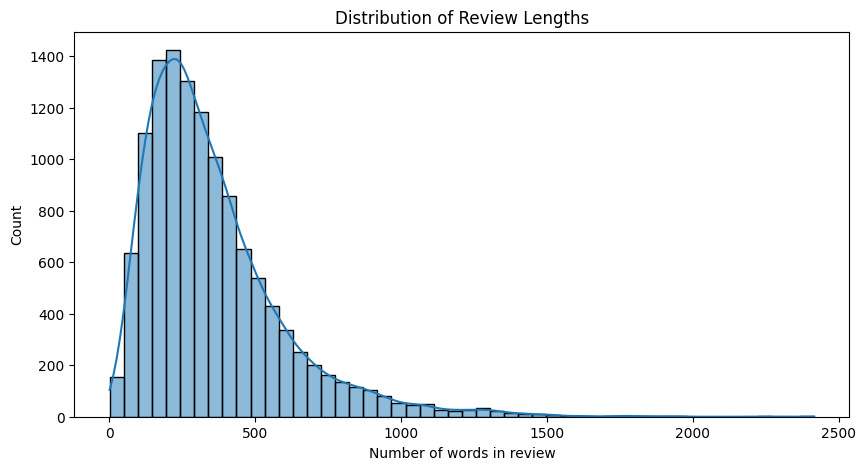

count    12391.000000
mean       354.765152
std        240.780516
min          1.000000
25%        189.000000
50%        298.000000
75%        454.000000
max       2416.000000
Name: review_length, dtype: float64


In [104]:

nips_reviews_df['review_length'] = nips_reviews_df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(nips_reviews_df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of words in review')
plt.show()

print(nips_reviews_df['review_length'].describe())


---

We can observe an increase in the number of accepted papers for NIPS as well, similar to ICLR. However, since the total number of submissions to NIPS is unknown, it is not possible to determine the acceptance rates.

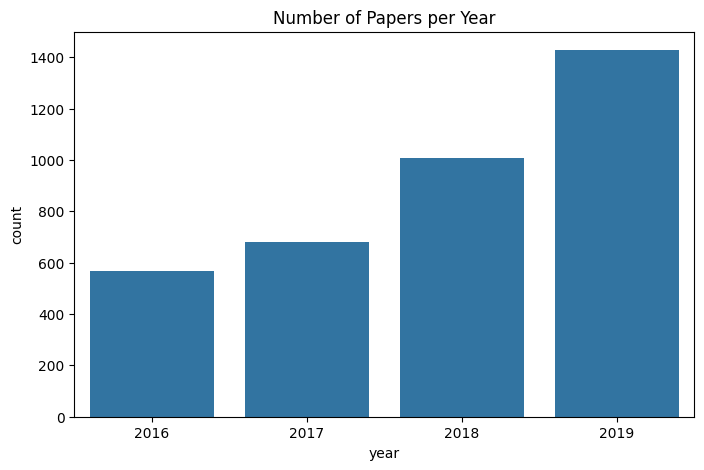

In [106]:
plt.figure(figsize=(8,5))
sns.countplot(data=nips_paper_df, x='year')
plt.title('Number of Papers per Year')
plt.show()


---



In [107]:
nips_paper_df

,paper_id,decision,hasReview,year
0,NIPS_2016_509,Accept,true,2016
1,NIPS_2016_102,Accept,true,2016
2,NIPS_2016_348,Accept,true,2016
3,NIPS_2016_135,Accept,true,2016
4,NIPS_2016_209,Accept,true,2016
...,...,...,...,...
3680,NIPS_2019_844,Accept,true,2019
3681,NIPS_2019_1300,Accept,true,2019
3682,NIPS_2019_680,Accept,true,2019
3683,NIPS_2019_1337,Accept,true,2019


In [108]:
nips_reviews_df

,review_id,paper_id,review,rating,review_length
0,NIPS_2016_358_1,NIPS_2016_358,"This paper proposes a new, general pairwise ra...",None,85
1,NIPS_2016_358_2,NIPS_2016_358,"This paper proposes a new choice model, which ...",None,260
2,NIPS_2016_358_3,NIPS_2016_358,The paper introduces Pairwise Choice Markov Ch...,None,220
3,NIPS_2016_358_4,NIPS_2016_358,This paper introduces a new choice model which...,None,163
4,NIPS_2016_358_5,NIPS_2016_358,This paper considers the problem of developing...,None,412
...,...,...,...,...,...
12386,NIPS_2019_955_2,NIPS_2019_955,1. Originality. The authors propose a novel me...,None,128
12387,NIPS_2019_955_3,NIPS_2019_955,I would consider Theorem 1 and analysis behind...,None,203
12388,NIPS_2019_1004_1,NIPS_2019_1004,Originality - it's the first time that semi-su...,None,67
12389,NIPS_2019_1004_2,NIPS_2019_1004,Originality: Previous theoretical work on the ...,None,194


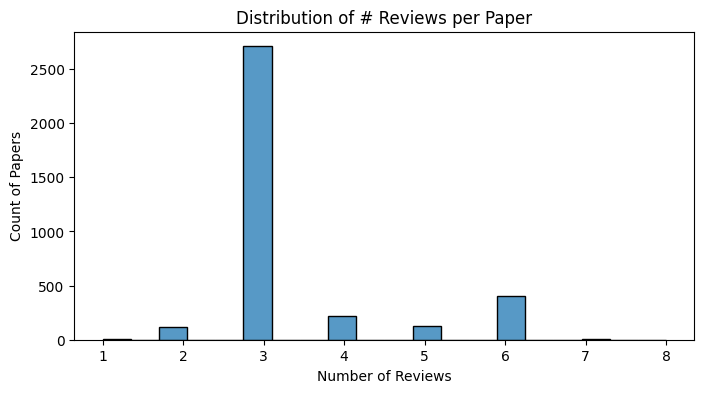

In [109]:
merged_nips = nips_reviews_df.merge(
    nips_paper_df[['paper_id','year']], on='paper_id', how='left'
)
reviews_per_paper = (
    merged_nips.groupby('paper_id')
          .size()
          .reset_index(name='n_reviews')
)
plt.figure(figsize=(8,4))
sns.histplot(reviews_per_paper['n_reviews'], bins=20, kde=False)
plt.title('Distribution of # Reviews per Paper')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Papers')
plt.show()